## Notebook 4: find ideal LR for Resnet model, and add dropout (find optimal dropout probability)

In [49]:
### NOTE:: LATEST RUN IS WITH NO DROPOUT AND NO PRETRAINED WEIGHTS


## Imports and Grab Data

In [1]:
from utils.notebook_2_utils import * 
import utils.notebook_2_utils as utils

training_df = pd.read_csv("data/training.csv")#.iloc[:400]
lookup_df = pd.read_csv("data/IdLookupTable.csv")
training_df.fillna(method = 'ffill',inplace = True)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
len(training_df)

7049

In [3]:
train_X, train_Y, val_X, val_Y = create_train_test_sets_nchw(training_df, normalize=True)

## ResNet Model
* Input shape:  64, 1, 96, 96 (nchw)
* Output shape: 64, 30 (nc)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
# from sklearn.model_selection import train_test_split
import torch.nn.functional as F

### Model Definition

In [5]:
# resnet = models.resnet18(pretrained=True)
resnet = models.resnet50(pretrained=False)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# resnet

In [7]:
resnet.conv1

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

## Control Panel

In [8]:
EPOCHS = 41
LEARNING_RATE = .05
BATCH_SIZE = 32


loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=LEARNING_RATE)





## Replace first and Last layers
* my input shape [32, 1, 96, 96] (NCHW) channels first

In [9]:
# ## FOR RESNET 18

# # freeze all layers
# # for param in resnet.parameters():
# #     param.requires_grad = False

# # replace last layer
# # resnet.fc = nn.Linear(512, 30) # 30 is the number of keypoints we want to predict


# # replacing the last layer with a dropout layer and then a linear layer 
# resnet.fc = nn.Sequential(
#     nn.Dropout(p=0.5),
#     nn.Linear(512, 30)
# )

# # relpace the first layer
# # resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# # replacing the first layer with dropout added
# resnet.conv1 = nn.Sequential(
#     nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
#     nn.Dropout(p=0.5)
# )
# # move to GPU
# resnet = resnet.to(device)


In [10]:
## !!! FOR RESNET 50 !!!

# freeze all layers
# for param in resnet.parameters():
#     param.requires_grad = False



# LAST LAYER
# replace last layer
resnet.fc = nn.Linear(2048, 30) # 30 is the number of keypoints we want to predict


# replacing the last layer with a dropout layer and then a linear layer 
# resnet.fc = nn.Sequential(
#     nn.Dropout(p=0.2),
#     nn.Linear(2048, 30)
# )


# FIRST LAYER
# relpace the first layer
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# replacing the first layer with dropout added
# resnet.conv1 = nn.Sequential(
#     nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
#     nn.Dropout(p=0.2)
# )
# move to GPU
resnet = resnet.to(device)

In [11]:
resnet.conv1

Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

### DataLoaders

In [12]:
torch.manual_seed(42)
from torch.utils.data import TensorDataset, DataLoader


# Put data to target device
train_X, train_Y = train_X.to(device), train_Y.to(device)
val_X, val_Y = val_X.to(device), val_Y.to(device)

train_dataset = TensorDataset(train_X, train_Y)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(val_X, val_Y)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Find Optimal LR

In [13]:
# final_lr = 10
# init_lr = 1e-10
# num_iters = 100

In [14]:
import matplotlib.pyplot as plt

def find_lr(model, train_loader, criterion, optimizer, init_lr=1e-8, final_lr=10, num_iters=100):
    """
    Finds the optimal learning rate for the model by gradually increasing the learning rate and plotting the loss.
    Args:
    - model (torch.nn.Module): the PyTorch model to train
    - train_loader (torch.utils.data.DataLoader): the training data loader
    - criterion (torch.nn.Module): the loss function
    - optimizer (torch.optim.Optimizer): the optimizer
    - init_lr (float): the initial learning rate
    - final_lr (float): the final learning rate
    - num_iters (int): the number of iterations to run
    """
    model.train()
    optimizer.param_groups[0]['lr'] = init_lr
    
    init, final = math.log(init_lr, 10), math.log(final_lr, 10)

    
    lr_steps = np.logspace(init, final, num=num_iters+1)
    lr = init_lr
    losses = []
    lrs = []
    lrs_dx = []
    
    for i, (inputs, targets) in enumerate(train_loader):
        if i >= num_iters:
            break
        
        optimizer.param_groups[0]['lr'] = lr
        inputs, targets = inputs.cuda(), targets.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        lrs.append(lr)
        if i != 0: 
            lrs_dx.append(loss.item() - losses[i-1]) 
        lr = lr_steps[i]
    
    # plot the learning rate vs. loss
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    
    max = np.argmin(lrs_dx)
    min = np.argmin(losses)
    
    text = "highest delta: " + str(lrs[max])[:7] + " lowest loss: " + str(lrs[min])[:7]
    plt.title(text)
    
    plt.scatter(lrs[min], losses[min], c="r")
    plt.scatter(lrs[max], losses[max], c="g")
    
    plt.show()
    return losses, lrs, lrs_dx

In [15]:
# losses, lrs, lrs_dx = find_lr(resnet, train_dataloader, loss_fn, optimizer, final_lr=100)

# CUTOFF

In [16]:
for X_batch, y_batch in train_dataloader:
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([32, 1, 96, 96]) torch.Size([32, 30])


In [17]:
resnet = resnet.to(device)

preds = resnet(X_batch)

In [18]:
preds.shape

torch.Size([32, 30])

In [19]:
loss = loss_fn(preds, y_batch)
loss

tensor(0.6170, device='cuda:0', grad_fn=<MseLossBackward0>)

In [20]:
# Checking to make sure the right layers are frozen

print("batch norm 1: ")
for param in resnet.bn1.parameters():
    print(param.requires_grad)
    
print("CONV1: ")
for param in resnet.conv1.parameters():
    print(param.requires_grad)

print("fc: ")
for param in resnet.fc.parameters():
    print(param.requires_grad)


batch norm 1: 
True
True
CONV1: 
True
fc: 
True
True


In [21]:
y_batch.shape

torch.Size([32, 30])

In [22]:
loss_fn(preds, y_batch)

tensor(0.6170, device='cuda:0', grad_fn=<MseLossBackward0>)

## Training Loop 

In [23]:
## GRADIENT ACCUMILATION

for epoch in range(EPOCHS):
    ### Training mode 
    resnet.train()

    
    # Set the number of batches to accumulate gradients over
    accumulation_steps = 16

    # Initialize a counter to keep track of the number of accumulated batches
    accumulation_counter = 0

    # Create an empty tensor to accumulate gradients over the accumulation steps
    grad_acc = {k: torch.zeros_like(v) for k, v in resnet.named_parameters()}

    for X_batch, y_batch in train_dataloader:

        # 1. Forward pass (model outputs raw logits)
        y_logits = resnet(X_batch)

        # 2. Calculate loss/accuracy
        loss = loss_fn(y_logits, y_batch)

        # 3. Loss backwards
        loss.backward()

        # 4. Accumulate gradients over the accumulation steps
        accumulation_counter += 1
        if accumulation_counter == accumulation_steps:
            for param_name, param in resnet.named_parameters():
                grad_acc[param_name] += param.grad / accumulation_steps
            accumulation_counter = 0

        # 5. Optimizer step (only update weights after accumulating gradients over accumulation_steps)
        if accumulation_counter == 0:
            for param_name, param in resnet.named_parameters():
                param.grad = grad_acc[param_name]
            optimizer.step()
            optimizer.zero_grad()

    # Check if there are any remaining accumulated gradients to update
    if accumulation_counter != 0:
        for param_name, param in resnet.named_parameters():
            param.grad = grad_acc[param_name]
        optimizer.step()
        optimizer.zero_grad()

    
    
    resnet.eval()
    with torch.inference_mode():
        for X_batch, y_batch in test_dataloader:
            test_logits = resnet(X_batch)
            test_loss = loss_fn(test_logits, y_batch)
            
            
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.03256 | Test Loss: 0.04138
Epoch: 10 | Loss: 0.00582 | Test Loss: 0.01075
Epoch: 20 | Loss: 0.00303 | Test Loss: 0.00259
Epoch: 30 | Loss: 0.00249 | Test Loss: 0.00260
Epoch: 40 | Loss: 0.00290 | Test Loss: 0.00169


In [24]:
# for epoch in range(EPOCHS):
#     ### Training mode 
#     resnet.train()

    
#     for X_batch, y_batch in train_dataloader:
#         # 1. Forward pass (model outputs raw logits)
#         y_logits = resnet(X_batch)
        
#         # 2. Calculate loss/accuracy
#         loss = loss_fn(y_logits, y_batch)
        
#         # 3. Optimizer zero grad
#         optimizer.zero_grad()
        
#         # 4. Loss backwards
#         loss.backward()
        
#         # 5. Optimizer step
#         optimizer.step()
    
    
#     resnet.eval()
#     with torch.inference_mode():
#         for X_batch, y_batch in test_dataloader:
#             test_logits = resnet(X_batch)
#             test_loss = loss_fn(test_logits, y_batch)

#     # Print out what's happening
#     if epoch % 8 == 0:
#         print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

In [25]:
# preds = resnet(val_X)

In [26]:
cpuModel = resnet.to("cpu")

In [27]:
preds = cpuModel(val_X.to("cpu"))

In [28]:
preds.shape

torch.Size([1409, 30])

In [29]:
val_Y.shape

torch.Size([1409, 30])

In [30]:
device = "cpu"

In [31]:
loss_fn(preds.to(device), val_Y.to(device))

tensor(0.0022, grad_fn=<MseLossBackward0>)

In [32]:
val_X.shape, preds.shape, val_Y.shape

(torch.Size([1409, 1, 96, 96]), torch.Size([1409, 30]), torch.Size([1409, 30]))

In [33]:
preds[0][1]

tensor(0.4356, grad_fn=<SelectBackward0>)

In [34]:
val_X[1].shape, val_X[1][0].shape

(torch.Size([1, 96, 96]), torch.Size([96, 96]))

In [35]:
def show_pred(X, preds, actual, index, point):
    plt.imshow(X[index][0],cmap='gray')

    plt.scatter(96* preds[index][point],96* preds[index][point + 1] ,c='r', marker='s', s=60, alpha=.5)
    plt.scatter(96*actual[index][point],96* actual[index][point+1],c='g', marker='s', s=60, alpha=.5)

    plt.legend(['predicted','actual'])
    


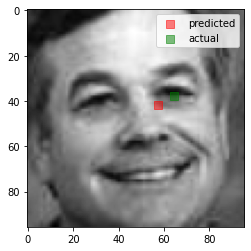

In [36]:
show_pred(val_X.to("cpu"), preds.to("cpu").detach().numpy(), val_Y.to("cpu").detach().numpy(), 0, 0)

In [37]:
val_X.shape

torch.Size([1409, 1, 96, 96])

In [38]:
val_X[0][0].shape

torch.Size([96, 96])

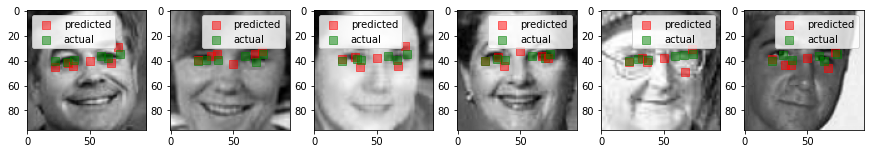

In [48]:
def show_all_preds(X, preds, actual, n, index, points=12):
    fig, ax = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        ax[i].imshow(X[index + i][0],cmap='gray')
        for point in range(0,points, 2):
            ax[i].scatter(preds[index + 1][point] * 96, 96 *preds[index + i][point + 1],c='r', marker='s', s=60, alpha=.5)
            ax[i].scatter(actual[index + i][point] * 96,96 *actual[index + i][point+1],c='g', marker='s', s=60, alpha=.5)
        ax[i].legend(['predicted','actual'])
    
show_all_preds(val_X.to("cpu"), preds.to("cpu").detach().numpy(), val_Y.to("cpu").detach().numpy(), 6, 0)

In [40]:
preds[0][0], preds[0][1]

(tensor(0.5997, grad_fn=<SelectBackward0>),
 tensor(0.4356, grad_fn=<SelectBackward0>))

In [41]:
val_Y[0][0], val_Y[0][1]

(tensor(0.6736, device='cuda:0'), tensor(0.3915, device='cuda:0'))

In [42]:
val_X[0][0]

tensor([[0.1843, 0.1529, 0.1255,  ..., 0.2902, 0.2980, 0.3137],
        [0.1725, 0.1529, 0.1333,  ..., 0.2863, 0.2941, 0.3059],
        [0.1686, 0.1608, 0.1451,  ..., 0.2863, 0.2941, 0.2980],
        ...,
        [0.2902, 0.2902, 0.2902,  ..., 0.2314, 0.2353, 0.2392],
        [0.2980, 0.2902, 0.2863,  ..., 0.2353, 0.2392, 0.2471],
        [0.3059, 0.2941, 0.2824,  ..., 0.2431, 0.2431, 0.2471]],
       device='cuda:0')

In [43]:
torch.save(resnet.state_dict(), "resnet50_dropout_120_01.pt")

In [44]:
torch.cuda.empty_cache()

In [45]:
# save predictions to CSV
train_X.shape, val_X.shape

(torch.Size([5640, 1, 96, 96]), torch.Size([1409, 1, 96, 96]))

In [46]:
all_X = torch.cat((train_X, val_X), 0)

In [47]:
all_preds = resnet(all_X)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same